I have previously appplied several regression models and analyzed their results. They were not reliable enough to be used for real-world portfolio management.

Another way to approach the main problem of stock market investing is to consider it as a classification problem: can a model predict well enough if a stock price will increase by 5% or more in the next day ?

Let's investigate by building the appropriate dataset, and train various classifiers.

In [1]:
!pip install -r requirements.txt

In [49]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, fbeta_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle

In [3]:
X_df = utils.get_stock_feature_dataset('ALNOV.PA')

C:\ProgramData\Miniconda3\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\ProgramData\Miniconda3\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [4]:
X_df.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,others_dlr,others_cr,cac40_Open,cac40_High,cac40_Low,cac40_Close,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close
Date,,,,,,,,,,,,,,,,,,,,,
2012-10-12,8.70,8.70,8.70,8.70,8.70,450.0,0.0,450.0,0.0,-24.874197,...,-2.561258,0.000000,3401.260010,3419.000000,3389.080078,3389.080078,2607.149902,2607.149902,2607.149902,2607.149902
2012-10-15,8.48,8.48,8.48,8.48,8.48,730.0,0.0,-280.0,0.0,-24.874197,...,-2.561258,-2.528736,3387.760010,3439.520020,3387.760010,3420.280029,2630.100098,2630.100098,2630.100098,2630.100098
2012-10-16,8.70,8.70,8.70,8.70,8.70,3000.0,0.0,2720.0,0.0,-24.874197,...,2.561258,0.000000,3443.600098,3500.939941,3428.969971,3500.939941,2686.030029,2686.030029,2686.030029,2686.030029
2012-10-17,8.72,8.72,8.72,8.72,8.72,800.0,0.0,3520.0,0.0,-24.874197,...,0.229621,0.229885,3503.820068,3530.790039,3494.350098,3527.500000,2704.060059,2704.060059,2704.060059,2704.060059
2012-10-18,8.83,8.83,8.83,8.83,8.83,138.0,0.0,3658.0,0.0,-24.874197,...,1.253578,1.494253,3527.760010,3542.580078,3508.399902,3535.179932,2709.370117,2709.370117,2709.370117,2709.370117


In [5]:
def make_labels_dataset(X_df, increase=0.05, label_name='increase_tomorrow'):
    '''
        increase: float between 0 and 1, equivalent to the desired % increase when multiplied by 100
        label_name: name for the column containing labels
    '''

    # Build the target dataset: label 1 if stock price increased by 5% or more in the following days, 0 otherwise
    y_df = pd.DataFrame(index=X_df.index, columns=[label_name])
    for i in range(len(X_df) - 1):
        increase_threshold = X_df['Adj Close'].iloc[i] + increase * X_df['Adj Close'].iloc[i]
        y_df.iloc[i] = 1 if X_df['Adj Close'].iloc[i+1] > increase_threshold else 0

    # Drop last row, for which there is no label
    X_df.drop(X_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    return X_df, y_df

In [6]:
X_df, y_df = make_labels_dataset(X_df)

In [7]:
y_df.tail()

,increase_tomorrow
Date,
2020-06-30,0
2020-07-01,0
2020-07-02,1
2020-07-03,0
2020-07-06,0


In [8]:
# Check that labels are correct:

# There was an important increase of our stock price on the market day just after April 9th 2020
print("Let's check if this {:.2f}% increase is correctly labeled...".format((X_df.loc['2020-04-14']['Adj Close'] - X_df.loc['2020-04-09']['Adj Close']) / X_df.loc['2020-04-09']['Adj Close'] * 100))

# Get index of April 9th 2020, the day before increase
idx = len(X_df.loc[:'2020-04-09']) - 1
assert np.array_equal(X_df.loc['2020-04-09'].values, X_df.iloc[idx].values)

# Check that its corresponding label is 1
assert y_df.iloc[idx]['increase_tomorrow'] == 1

print('Good!')

Let's check if this 31.62% increase is correctly labeled...
Good!


Let's split dataset into testing and training datasets, and normalize them:

In [9]:
# Split dataset into 90-10% training-testing sets.
# They can be shuffled safely, since the specificities of
# time series are not relevant anymore for our classification task
train_X, train_y, test_X, test_y = utils.split_dataset(X_df, y_df, train_size=0.9, do_shuffle=True)

In [10]:
# Check if there are both labels in the training and testing sets
print('training set contains {:.2f}% records labeled as 1'.format((train_y.values.sum()/train_y.shape[0] * 100)))
print('testing set contains {:.2f}% records labeled as 1'.format(test_y.values.sum()/test_y.shape[0] * 100))

training set contains 7.27% records labeled as 1
testing set contains 9.14% records labeled as 1


In [11]:
# Scale all values to have the same range:
X_scaler = MinMaxScaler().fit(train_X.values)

train_X_scaled = X_scaler.transform(train_X.values)
test_X_scaled = X_scaler.transform(test_X.values)

train_y = train_y.values.reshape(-1)
test_y = test_y.values.reshape(-1)

I will first use the benchmark algorithm 'DummyClassifier', and then apply and test LinearSVC, LogisticRegression, SVC, KNeighborsClassifier, RandomForestClassifier and AdaBoostClassifier.

The metrics I will evaluate for this classification task are accuracy, precision and Fbeta-score with beta=0.5 to penalize false positives more.

In [12]:
def print_metrics(y_true, y_pred):
    print('\taccuracy: {:.2f}%'.format(accuracy_score(y_true, y_pred) * 100))
    print('\tprecision: {:.2f}%'.format(precision_score(y_true, y_pred) * 100))
    print('\tfbeta: {:.3f}'.format(fbeta_score(y_true, y_pred, beta=0.5)))

def train_eval(model, train_X, train_y, test_X, test_y):
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    print('Results:')
    print_metrics(test_y, pred_y)

In [13]:
%%time
train_eval(DummyClassifier(), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 85.79%
	precision: 18.75%
	fbeta: 0.183
Wall time: 15.6 ms


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [14]:
%%time
train_eval(LinearSVC(class_weight='balanced', max_iter=100000), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 78.17%
	precision: 26.42%
	fbeta: 0.304
Wall time: 2.16 s


In [15]:
%%time
train_eval(SGDClassifier(class_weight='balanced'), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 67.01%
	precision: 18.67%
	fbeta: 0.220
Wall time: 31.3 ms


In [16]:
%%time
train_eval(LogisticRegression(class_weight='balanced', max_iter=100000), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 76.14%
	precision: 24.56%
	fbeta: 0.285
Wall time: 132 ms


In [17]:
%%time
train_eval(SVC(class_weight='balanced'), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 80.71%
	precision: 27.27%
	fbeta: 0.309
Wall time: 285 ms


In [18]:
%%time
train_eval(KNeighborsClassifier(), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 90.36%
	precision: 42.86%
	fbeta: 0.326
Wall time: 62.5 ms


In [19]:
%%time
train_eval(RandomForestClassifier(n_estimators=2000, class_weight='balanced'), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 90.36%
	precision: 33.33%
	fbeta: 0.167
Wall time: 14.1 s


In [20]:
%%time
weak_learner = DecisionTreeClassifier(max_depth=10, class_weight='balanced')
ada_model = AdaBoostClassifier(weak_learner, algorithm="SAMME", n_estimators=2000)
train_eval(ada_model, train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 88.83%
	precision: 16.67%
	fbeta: 0.119
Wall time: 2min 43s


Precision and fbeta scores obtained by all these classifiers are not very good, the current dataset is most probably not adapted to this classification task.

Let's then try to get less overfitting and better precision and fbeta scores by aggregating a lot more stocks than just one in our training and testing sets, and re-train all these models on much more data points:

In [21]:
symbol_list = ['AI.PA', 'SAF.PA', 'GNFT.PA', 'ALNOV.PA', 'FDJ.PA', 'ETL.PA', 'DBV.PA',
              'BN.PA', 'KER.PA', 'AIR.PA', 'ENGI.PA', 'FP.PA', 'DG.PA', 'VIV.PA',
              'UG.PA', 'SU.PA', 'VIE.PA', 'ALPHA.PA', 'ALBIO.PA', 'CRI.PA', 'ALERS.PA']

X_df = pd.DataFrame()
y_df = pd.DataFrame()

for symbol in symbol_list:
    print('Processing {}...'.format(symbol))
    symbol_X_df = utils.get_stock_feature_dataset(symbol)
    symbol_X_df, symbol_y_df = make_labels_dataset(symbol_X_df)

    # reset index since dates are not required for classification
    X_df = X_df.append(symbol_X_df.reset_index(drop=True), ignore_index=True)
    y_df = y_df.append(symbol_y_df.reset_index(drop=True), ignore_index=True)
    print('Done! new X_df shape: {}, new y_df shape: {}'.format(X_df.shape, y_df.shape))
    print('')

Processing AI.PA...


C:\ProgramData\Miniconda3\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\ProgramData\Miniconda3\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


Done! new X_df shape: (5273, 86), new y_df shape: (5273, 1)

Processing SAF.PA...
Done! new X_df shape: (10546, 86), new y_df shape: (10546, 1)

Processing GNFT.PA...
Done! new X_df shape: (12602, 86), new y_df shape: (12602, 1)

Processing ALNOV.PA...
Done! new X_df shape: (14574, 86), new y_df shape: (14574, 1)

Processing FDJ.PA...
Done! new X_df shape: (14732, 86), new y_df shape: (14732, 1)

Processing ETL.PA...
Done! new X_df shape: (18461, 86), new y_df shape: (18461, 1)

Processing DBV.PA...
Done! new X_df shape: (20517, 86), new y_df shape: (20517, 1)

Processing BN.PA...
Done! new X_df shape: (28289, 86), new y_df shape: (28289, 1)

Processing KER.PA...
Done! new X_df shape: (33562, 86), new y_df shape: (33562, 1)

Processing AIR.PA...
Done! new X_df shape: (38400, 86), new y_df shape: (38400, 1)

Processing ENGI.PA...
Done! new X_df shape: (43673, 86), new y_df shape: (43673, 1)

Processing FP.PA...
Done! new X_df shape: (48946, 86), new y_df shape: (48946, 1)

Processing DG

In [22]:
X_df = X_df.astype(float)
X_df.replace(np.inf, np.nan, inplace=True)
X_df.replace(-np.inf, np.nan, inplace=True)
X_df.interpolate(axis=0, limit_direction='both', inplace=True)

In [23]:
X_df.isna().sum().sum()

0

In [24]:
X_df.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,others_dlr,others_cr,cac40_Open,cac40_High,cac40_Low,cac40_Close,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close
0,34.854301,36.306599,34.771301,35.061798,10.226519,904282.0,-5.620798e+05,904282.0,-0.402545,-833509.084988,...,-4.539366,0.000000,6024.379883,6102.120117,5901.770020,5917.370117,4035.110107,4035.110107,4035.110107,4035.110107
1,35.061798,34.999500,32.613701,33.505798,9.772677,1381445.0,-9.104260e+05,-477163.0,-0.402545,-833509.084988,...,-4.539366,-4.437879,5922.229980,5925.069824,5657.200195,5672.020020,3873.149902,3873.149902,3873.149902,3873.149902
2,32.779701,33.402100,32.281700,33.194599,9.681908,853763.0,-3.729013e+05,-1330926.0,-0.402545,-833509.084988,...,-0.933132,-5.325451,5521.830078,5589.500000,5461.589844,5479.700195,3743.870117,3743.870117,3743.870117,3743.870117
3,32.758900,36.223598,32.696701,35.580399,10.377778,1387137.0,5.082923e+05,56211.0,-0.402545,-833509.084988,...,6.940771,1.479106,5485.930176,5530.259766,5388.850098,5450.109863,3728.080078,3728.080078,3728.080078,3728.080078
4,35.580399,37.136398,34.958000,35.144798,10.250728,2198233.0,-1.312943e+06,-2142022.0,-0.402545,-833509.084988,...,-1.231828,0.236725,5423.879883,5561.689941,5423.879883,5539.609863,3794.070068,3794.070068,3794.070068,3794.070068


In [25]:
y_df.head()

,increase_tomorrow
0,0
1,0
2,1
3,0
4,0


In [26]:
train_X, train_y, test_X, test_y = utils.split_dataset(X_df, y_df, train_size=0.9, do_shuffle=True)

In [27]:
# Check if there are both labels in the training and testing sets
print('training set contains {:.2f}% records labeled as 1'.format((train_y.values.sum()/train_y.shape[0] * 100)))
print('testing set contains {:.2f}% records labeled as 1'.format(test_y.values.sum()/test_y.shape[0] * 100))

training set contains 3.98% records labeled as 1
testing set contains 4.08% records labeled as 1


In [28]:
# Scale all values to have the same range:
X_scaler = MinMaxScaler().fit(train_X.values)

train_X_scaled = X_scaler.transform(train_X.values)
test_X_scaled = X_scaler.transform(test_X.values)

train_y = train_y.values.reshape(-1)
test_y = test_y.values.reshape(-1)

In [29]:
%%time
train_eval(DummyClassifier(), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 92.38%
	precision: 3.63%
	fbeta: 0.036
Wall time: 15.6 ms


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [30]:
%%time
train_eval(LinearSVC(class_weight='balanced', max_iter=100000), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 84.77%
	precision: 18.45%
	fbeta: 0.218
Wall time: 7min 14s


In [31]:
%%time
train_eval(LogisticRegression(class_weight='balanced', max_iter=100000), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 84.17%
	precision: 17.72%
	fbeta: 0.210
Wall time: 5.56 s


In [32]:
%%time
train_eval(SVC(class_weight='balanced'), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 89.64%
	precision: 24.84%
	fbeta: 0.287
Wall time: 7min 59s


In [33]:
%%time
train_eval(SGDClassifier(class_weight='balanced'), train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 94.84%
	precision: 41.03%
	fbeta: 0.439
Wall time: 793 ms


In [40]:
%%time
kn_model = KNeighborsClassifier()
train_eval(kn_model, train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 97.64%
	precision: 94.61%
	fbeta: 0.773
Wall time: 1min 14s


In [41]:
%%time
rf_model = RandomForestClassifier(n_estimators=2000, class_weight='balanced')
train_eval(rf_model, train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 97.75%
	precision: 99.38%
	fbeta: 0.802
Wall time: 22min 27s


In [36]:
%%time
weak_learner = DecisionTreeClassifier(max_depth=10, class_weight='balanced')
ada_model = AdaBoostClassifier(weak_learner, algorithm="SAMME", n_estimators=2000)
train_eval(ada_model, train_X_scaled, train_y, test_X_scaled, test_y)

Results:
	accuracy: 92.30%
	precision: 29.40%
	fbeta: 0.329
Wall time: 51.1 s


KNeighborsClassifier and RandomForestClassifier got very good results, let's write them to disk:

In [42]:
# Save KNN model to disk
outfile = open('kneighbors-clf.pickle', 'wb')
pickle.dump(kn_model, outfile)
outfile.close()

In [45]:
# Save model to disk
outfile = open('randomforest-clf.pickle', 'wb')
pickle.dump(rf_model, outfile)
outfile.close()

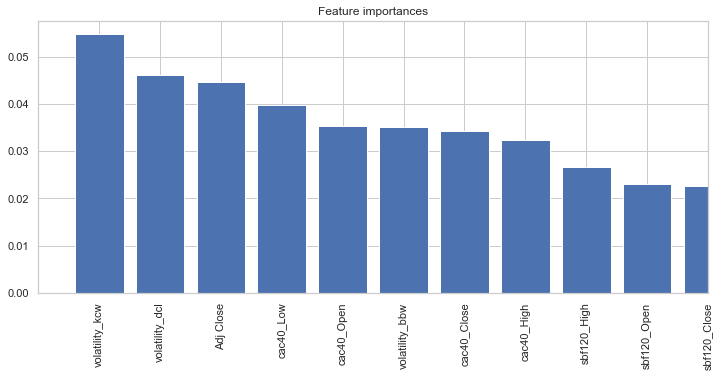

In [67]:
# Plot the top N most important features used by RandomForestClassifier
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

top_n = 10

plt.figure(figsize=(12, 5))

plt.title("Feature importances")
plt.bar(range(top_n+1), importances[indices[:top_n+1]], align="center")
plt.xticks(range(top_n+1), X_df.columns[indices[:top_n+1]], rotation=90)
plt.xlim([-1, top_n])
plt.show()

Like the PCA study performed earlier, the feature importance plot shows that the RF model works by using a top-10-feature mix of both traditional technical analysis indicators and features related to the main market indices of the stocks analyzed.